In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'

NUM1_RANGE = (0,99)
NUM2_RANGE = (0,99)

COMPARE_RHS = False
SPACE_PADDING = False
EQUATIONS_PER_SENTENCE = 1
INIT_WEIGHTS = False

TRAINING_SAMPLE_SIZE = 5000
TEST_SAMPLE_SIZE = 100
EPOCHS = 100
LEARNING_RATE = 1e-3

MAX_LEN = 16
EMBED_SIZE = 18 #384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1

In [3]:
assert(EQUATIONS_PER_SENTENCE == 1 or COMPARE_RHS == False)

### Transformer for Calculation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [5]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        sample = []
        for _ in range(EQUATIONS_PER_SENTENCE):
            sample.append(AdditionDataset.generate_one_sample(operator, reverse_in, reverse_out))

        return ' '.join(sample)

    @staticmethod
    def generate_one_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        sentence = num1+operator+num2+'='+result
        if SPACE_PADDING:
            sentence += ' '*MAX_LEN
        return sentence

In [8]:
# TODO: replace and delete
n_embd = EMBED_SIZE
block_size = MAX_LEN
n_layer = NUM_LAYERS
dropout = DROPOUT

In [9]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11, ' ': 12}
VOCAB_SIZE = len(ONEHOT_IDX)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return ''.join(ONEHOT_IDX.keys())[idx]

def pca_labels():
    return [c for c in ''.join(ONEHOT_IDX.keys()) if c not in [' ']]

In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [11]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [14]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(max_len, embed_size)
        self.blocks = nn.Sequential(*[Block(embed_size, n_head=num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_size) # final layer norm
        self.lm_head = nn.Linear(embed_size, vocab_size)

        if INIT_WEIGHTS:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        return logits


In [15]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [16]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [17]:
model = model.to(device)
model

TransformerDecoderModel(
  (token_embedding_table): Embedding(13, 18)
  (position_embedding_table): Embedding(16, 18)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=18, out_features=3, bias=False)
            (query): Linear(in_features=18, out_features=3, bias=False)
            (value): Linear(in_features=18, out_features=3, bias=False)
            (dropout): Dropout(p=0, inplace=False)
          )
        )
        (proj): Linear(in_features=18, out_features=18, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=18, out_features=72, bias=True)
          (1): ReLU()
          (2): Linear(in_features=72, out_features=18, bias=True)
          (3): Dropout(p=0, inplace=False)
        )
      )
      (ln1): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
      (ln2)

In [18]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png', bbox_inches='tight')
        plt.close()

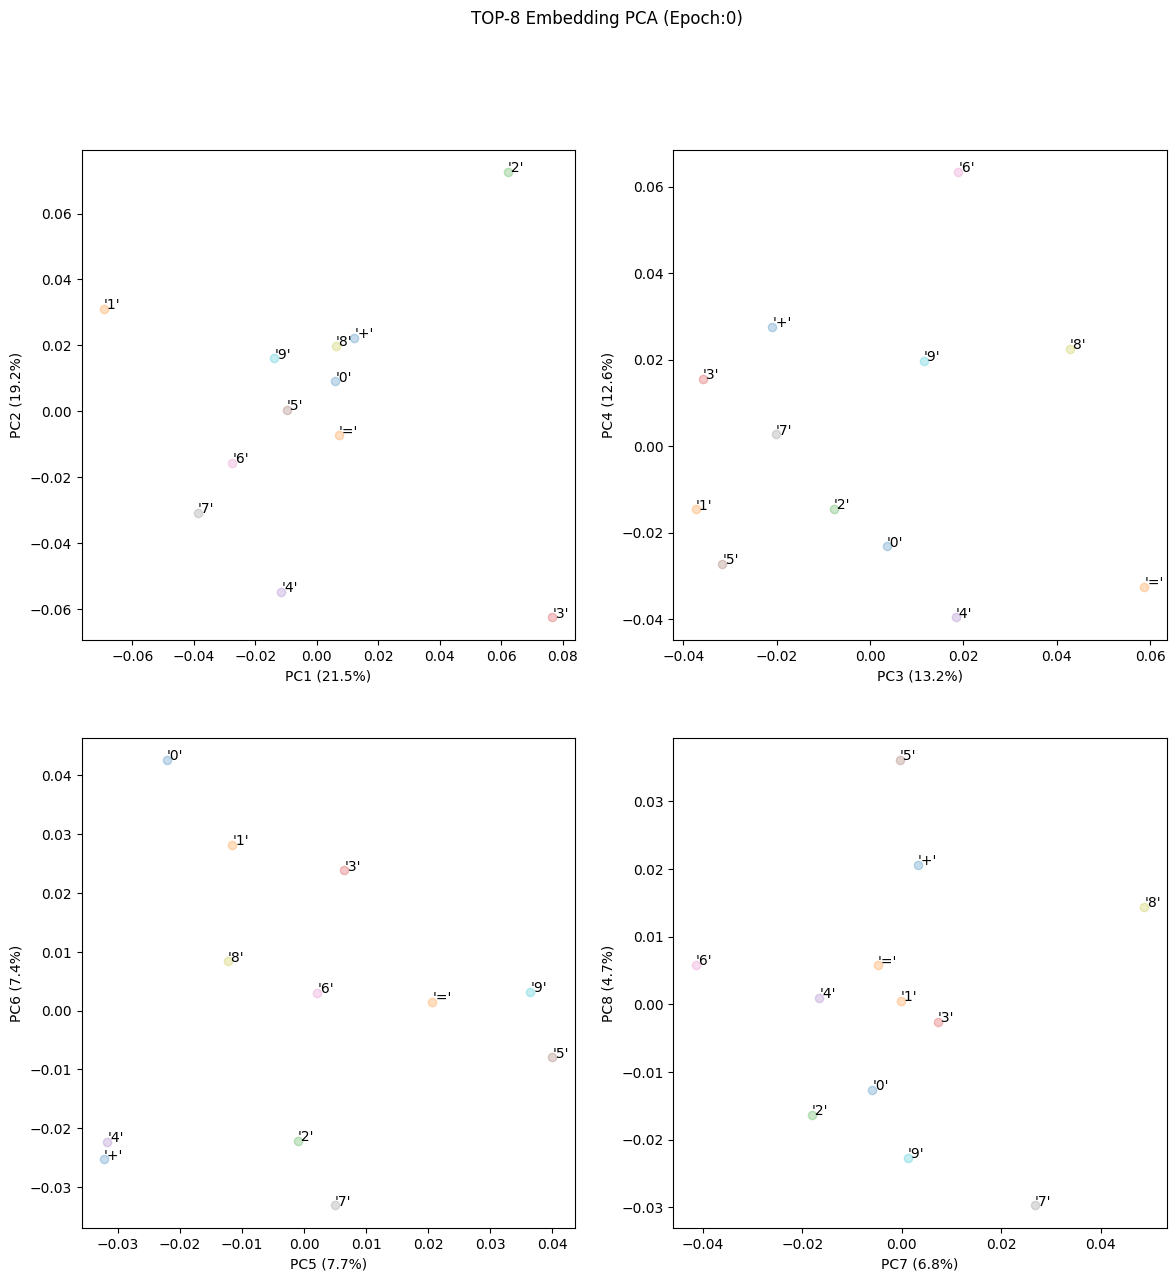

In [19]:
def vis_pca_in_epoch(epoch=0, loss=None, accuracy=None):
    emb_func = model.token_embedding_table
    
    labels = pca_labels()
    emb_vecs = emb_func(torch.tensor([char_to_idx(token) for token in labels]).to(device))
    
    info = f'Epoch:{epoch}'

    if loss is not None:
        info += f', Loss:{loss:.2f}'
    if accuracy is not None:
        info += f', Accuracy:{accuracy:.4f}'

    vis_pca(emb_vecs, labels, title=f'TOP-8 Embedding PCA ({info})', show=True)

vis_pca_in_epoch()

  0%|          | 0/5000 [00:00<?, ?it/s]

input_tensor tensor([[ 3,  5, 10,  3,  9, 11,  6,  4]], device='cuda:0')
target_tensor tensor([[ 5, 10,  3,  9, 11,  6,  4,  1]], device='cuda:0')


100%|██████████| 5000/5000 [01:29<00:00, 55.64it/s]


Epoch 1, Loss: 1.649180222916603


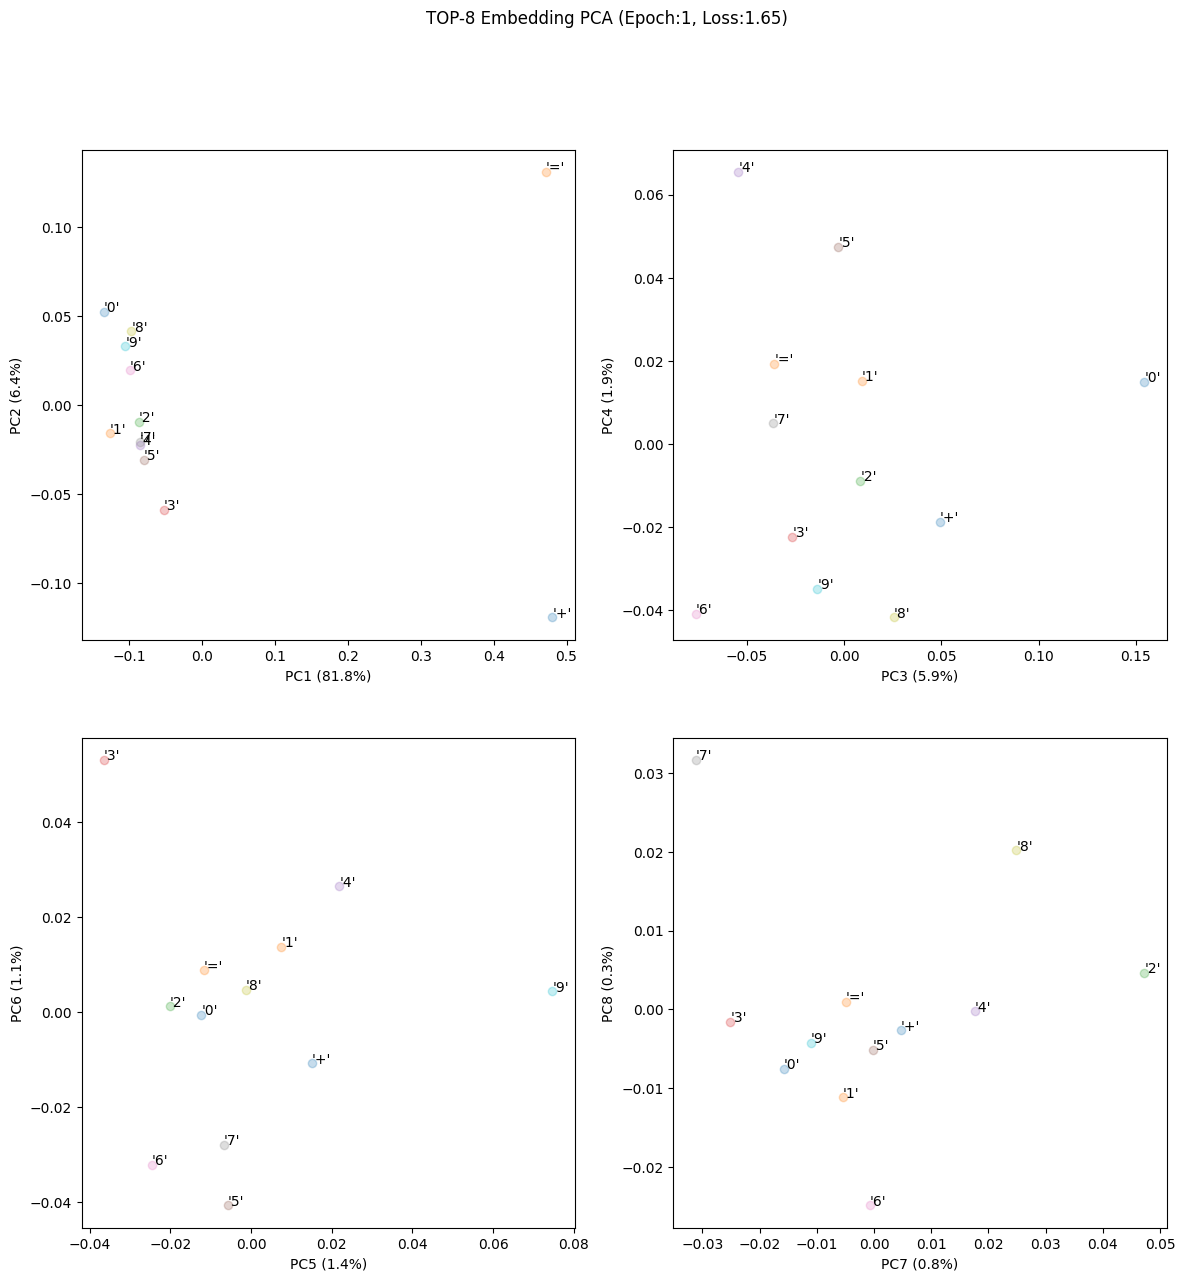

100%|██████████| 5000/5000 [01:35<00:00, 52.44it/s]


Epoch 2, Loss: 1.6085534071445464


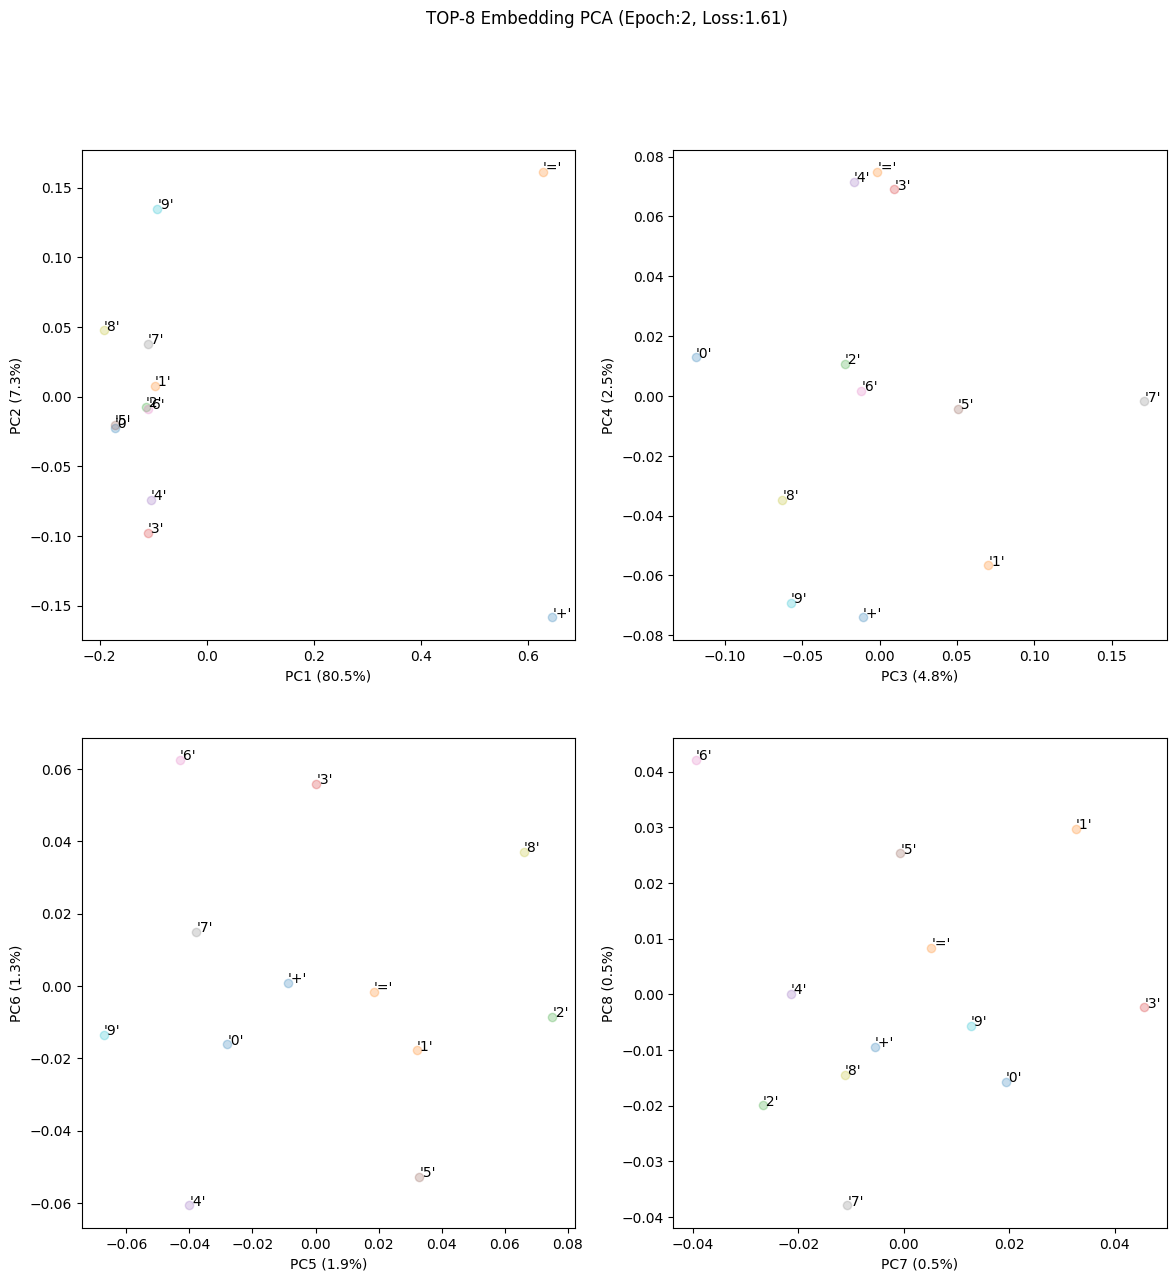

100%|██████████| 5000/5000 [01:30<00:00, 55.47it/s]


Epoch 3, Loss: 1.6056961047172547


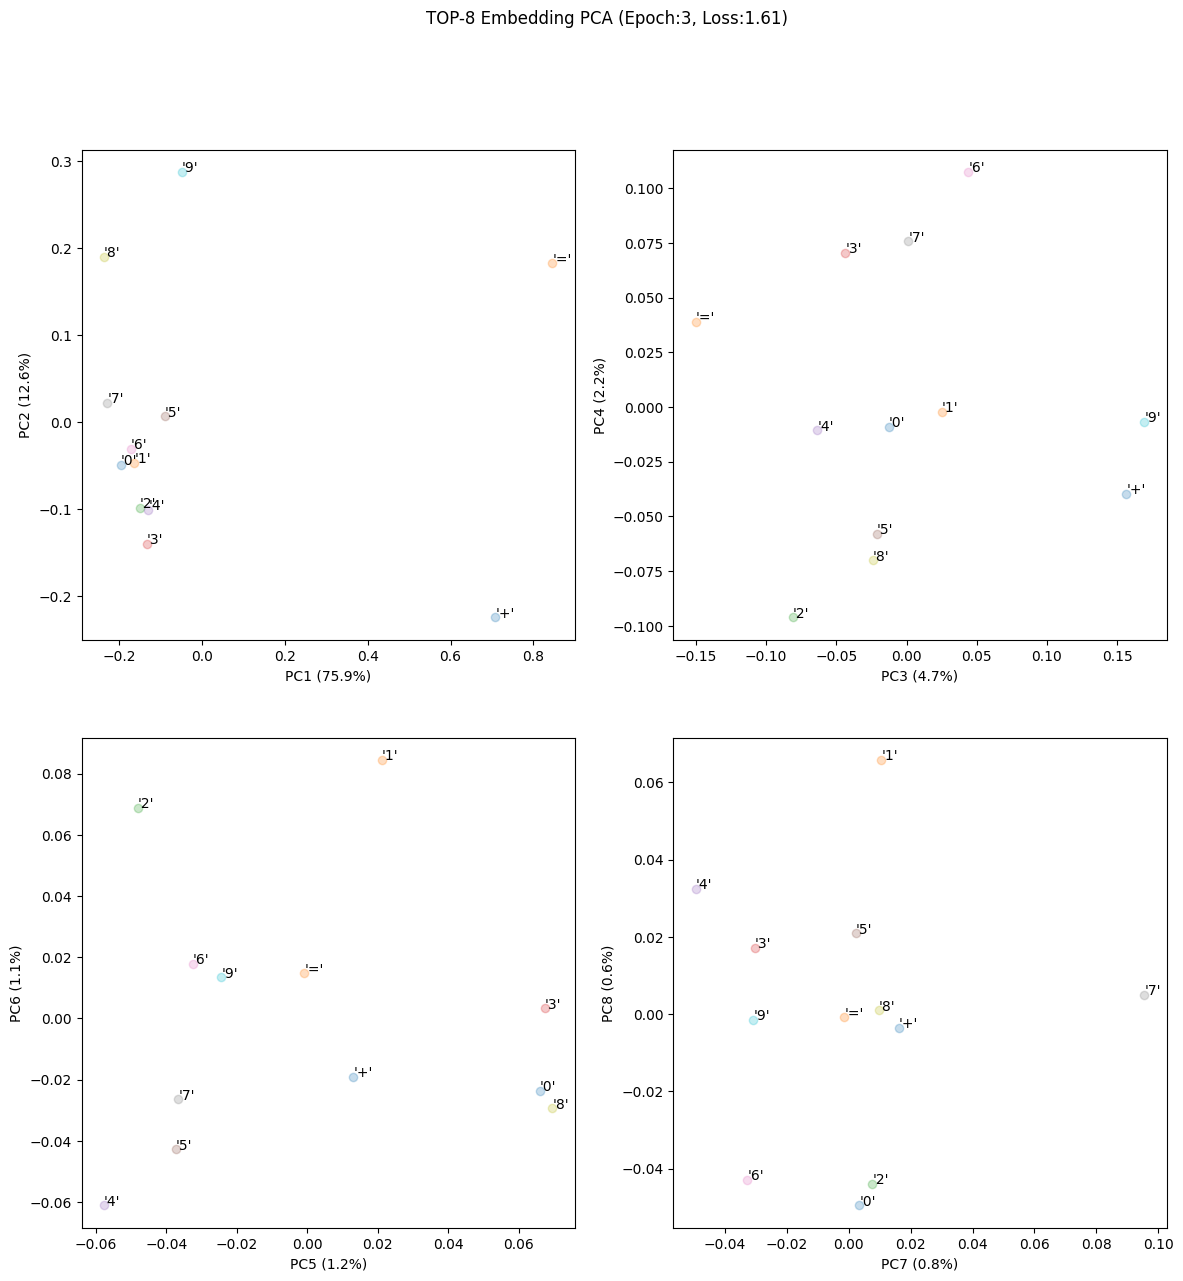

100%|██████████| 5000/5000 [01:27<00:00, 56.94it/s]


Epoch 4, Loss: 1.6020122543096542


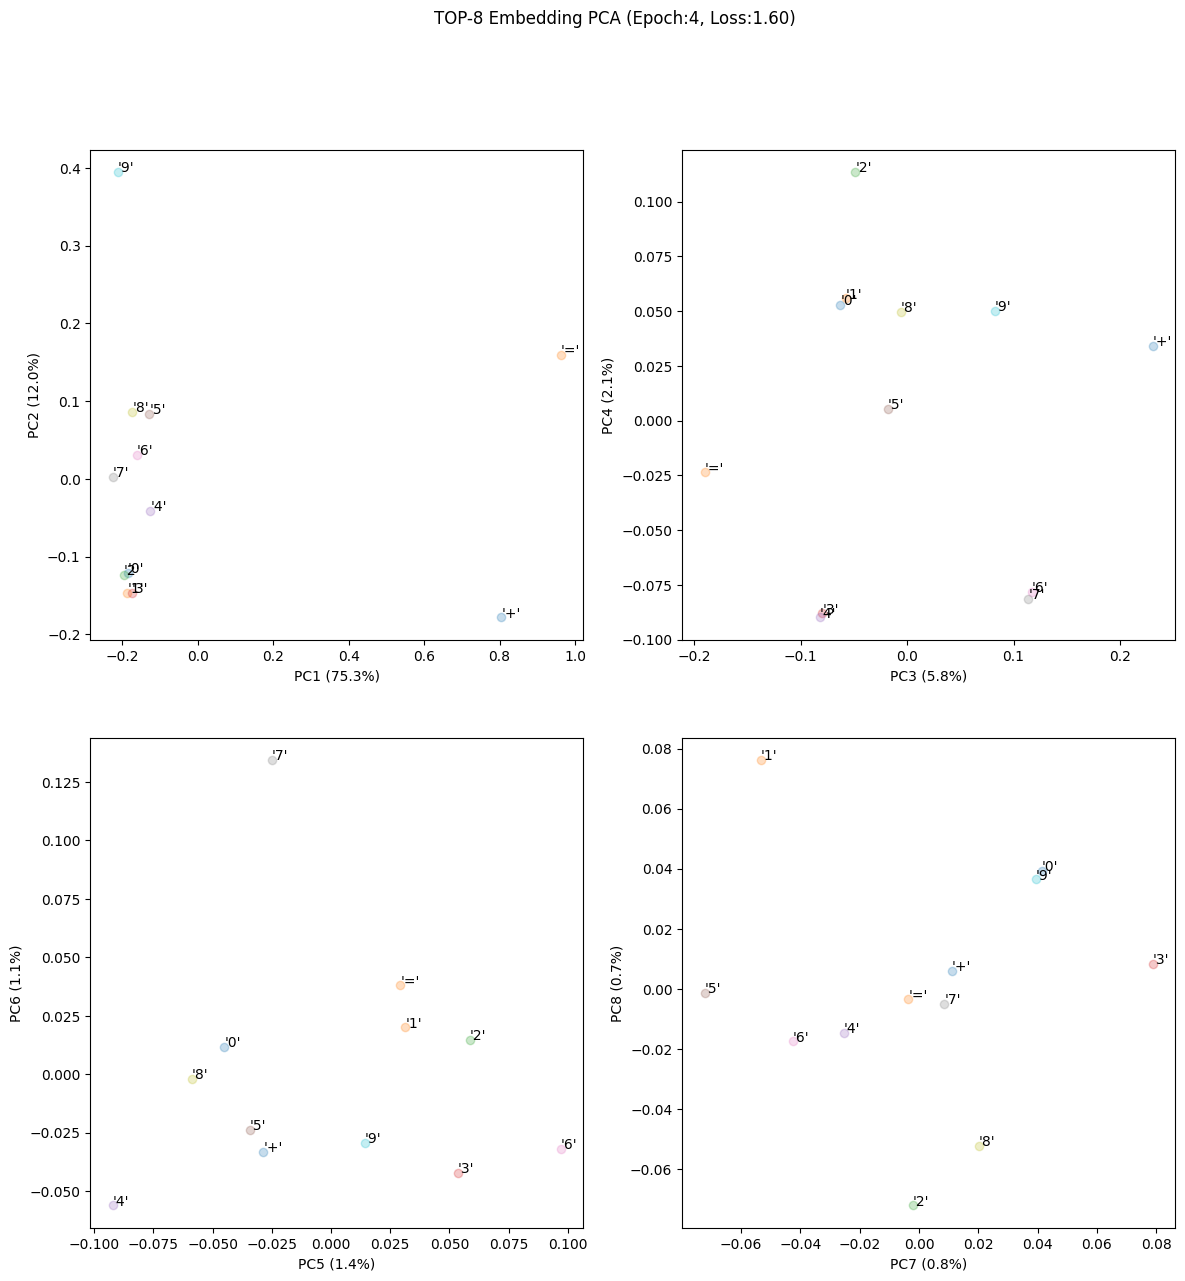

100%|██████████| 5000/5000 [01:26<00:00, 57.64it/s]


Epoch 5, Loss: 1.5990496906518936


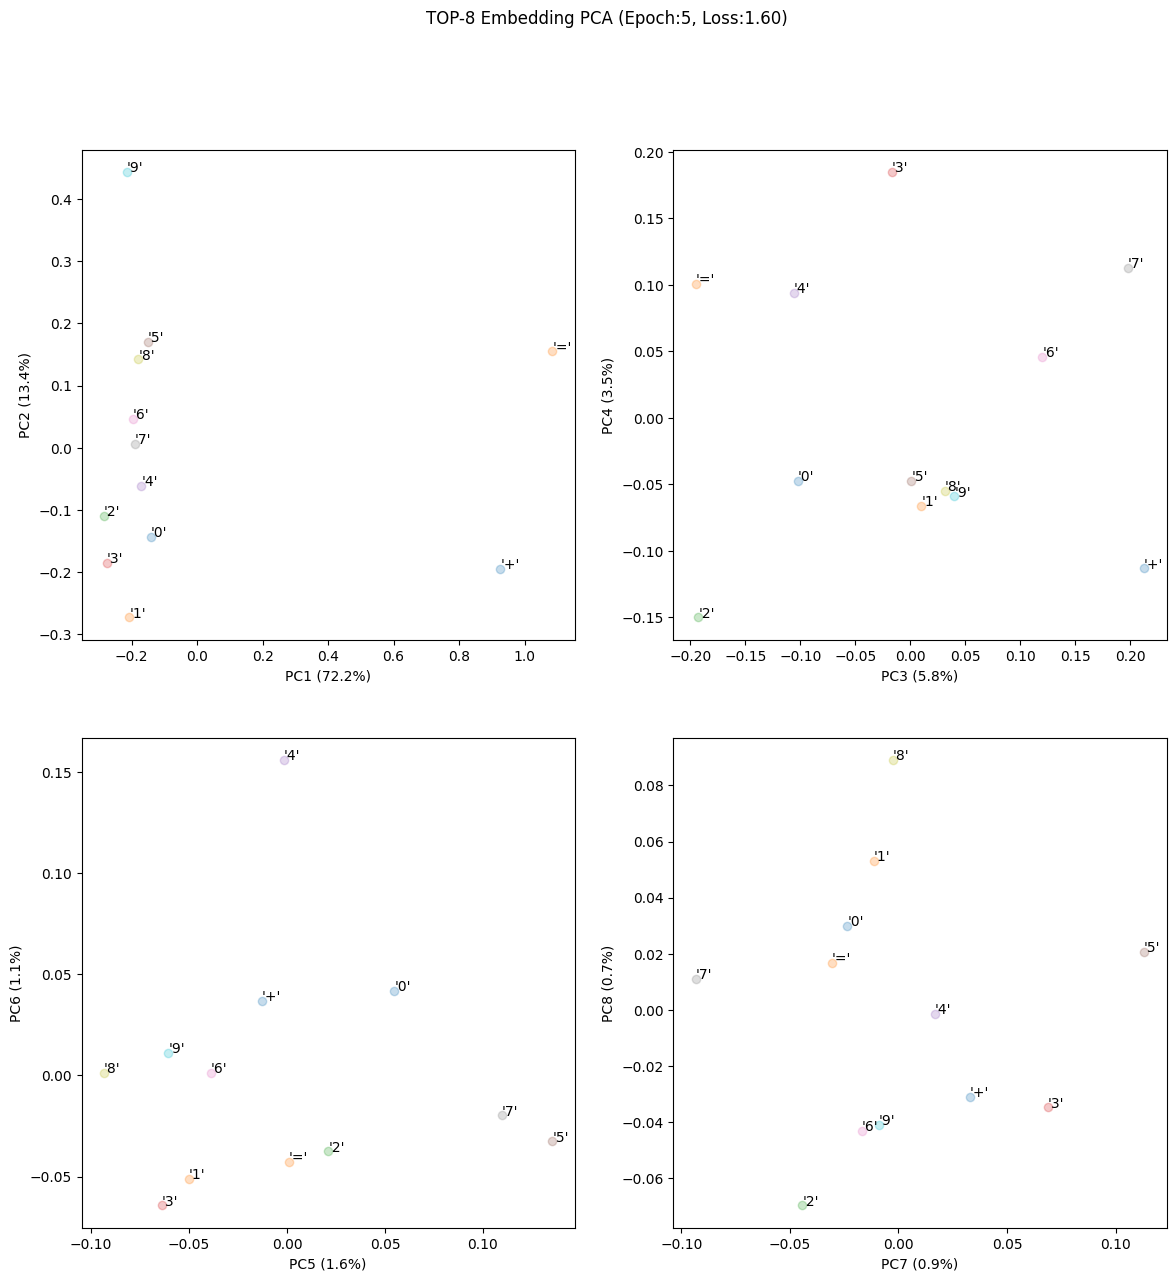

100%|██████████| 5000/5000 [01:26<00:00, 57.77it/s]


Epoch 6, Loss: 1.5830789224147797


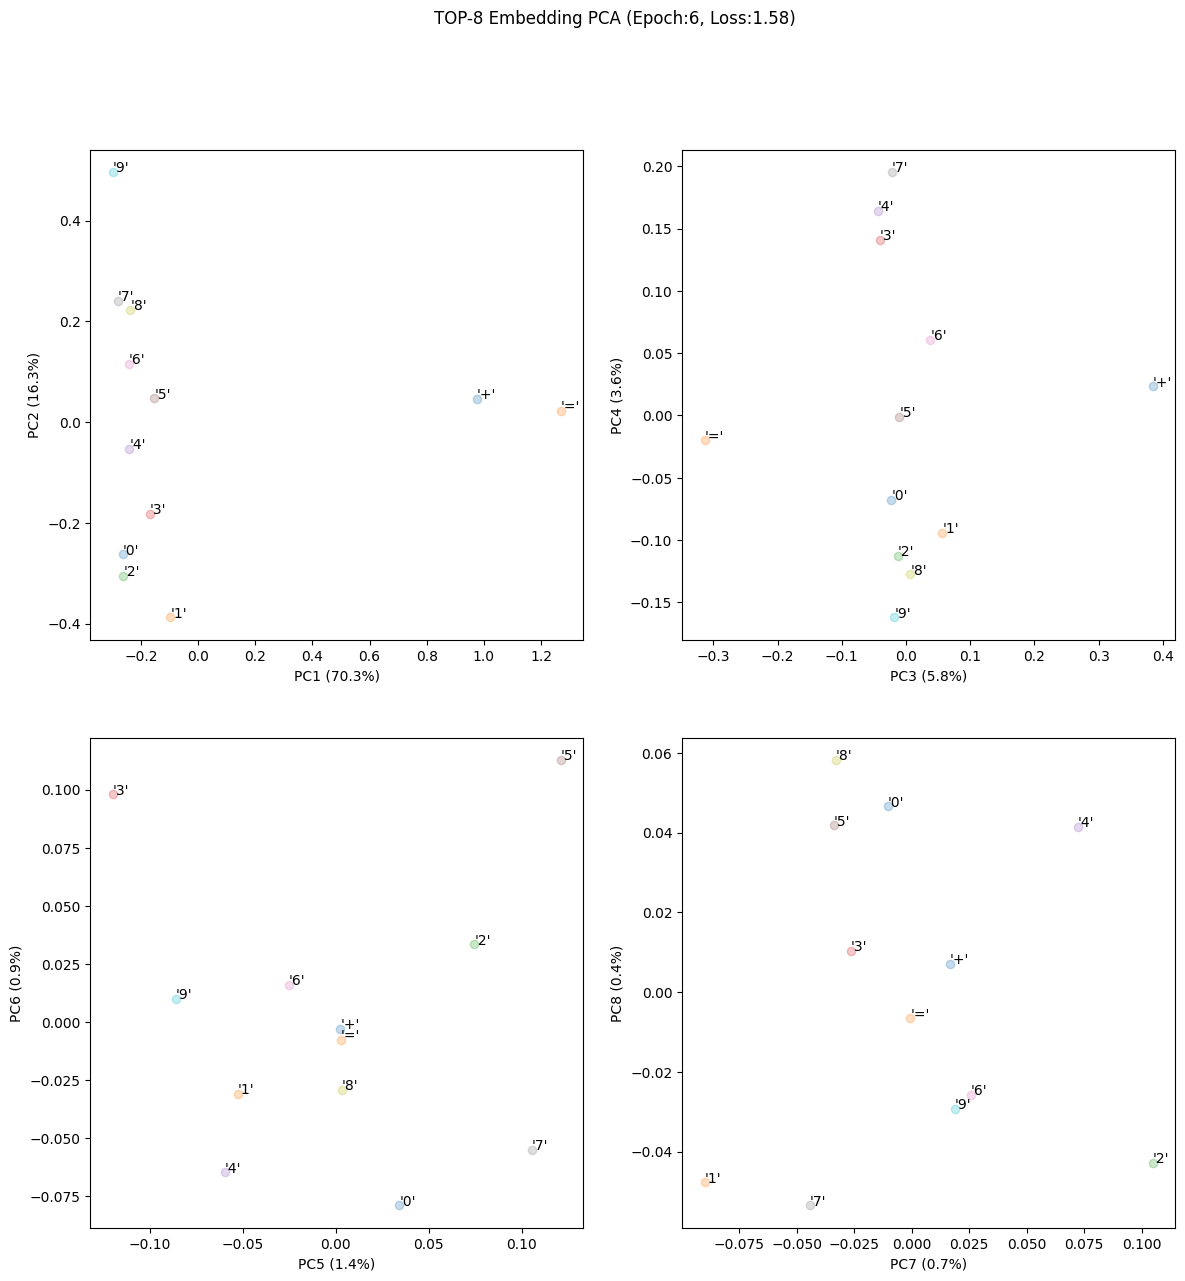

100%|██████████| 5000/5000 [01:28<00:00, 56.52it/s]


Epoch 7, Loss: 1.5085409051656724


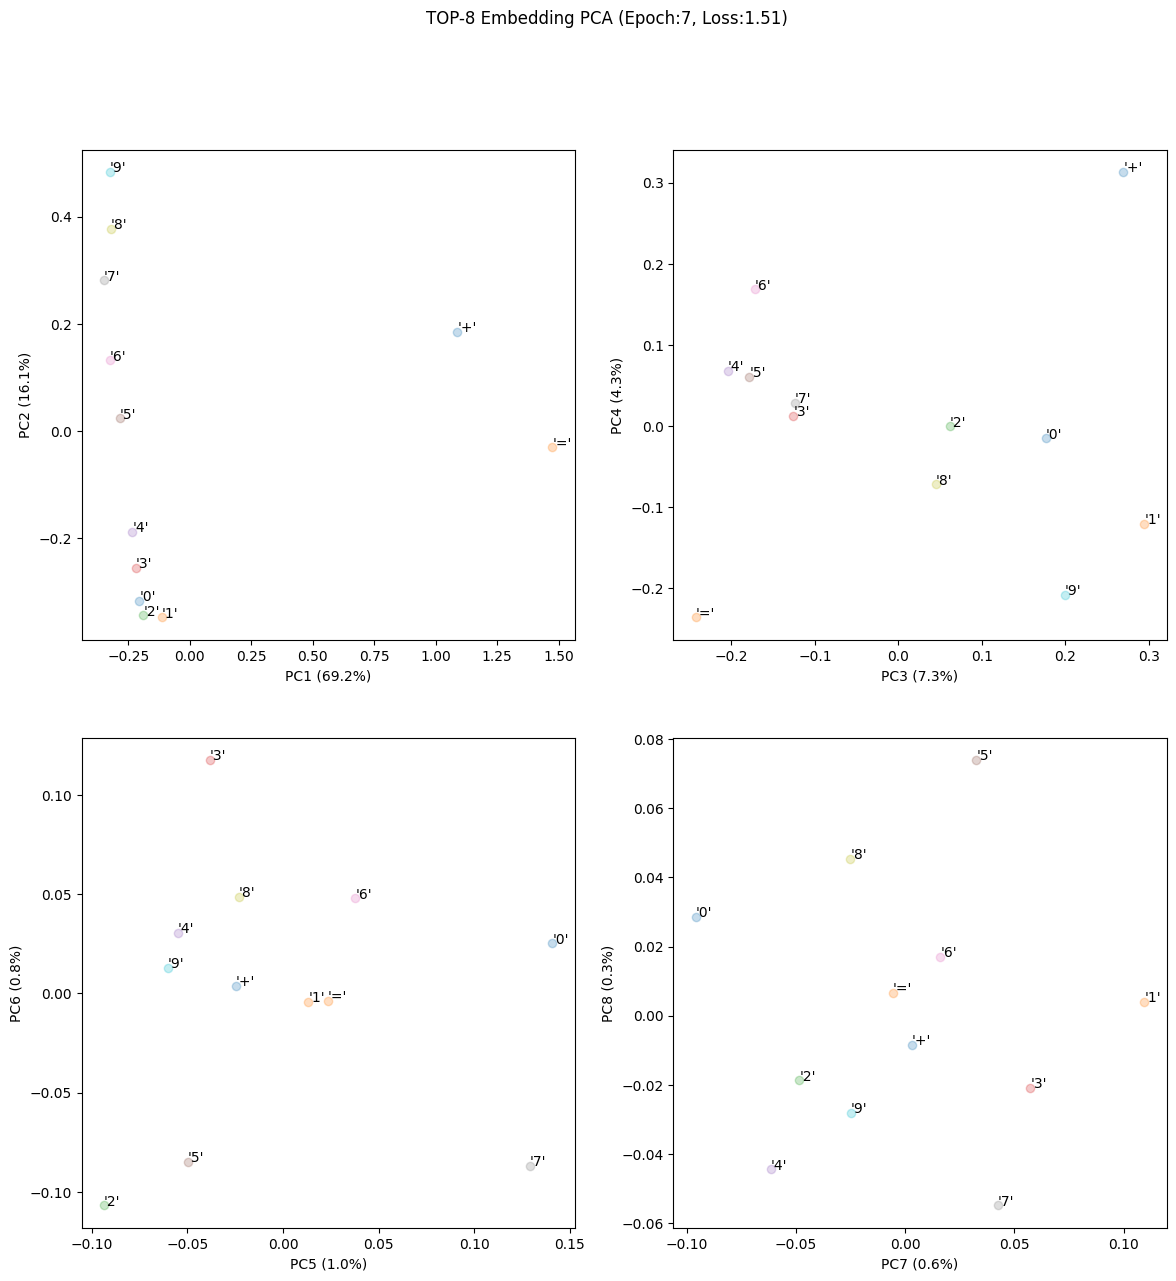

100%|██████████| 5000/5000 [01:35<00:00, 52.45it/s]


Epoch 8, Loss: 1.3898966000795365


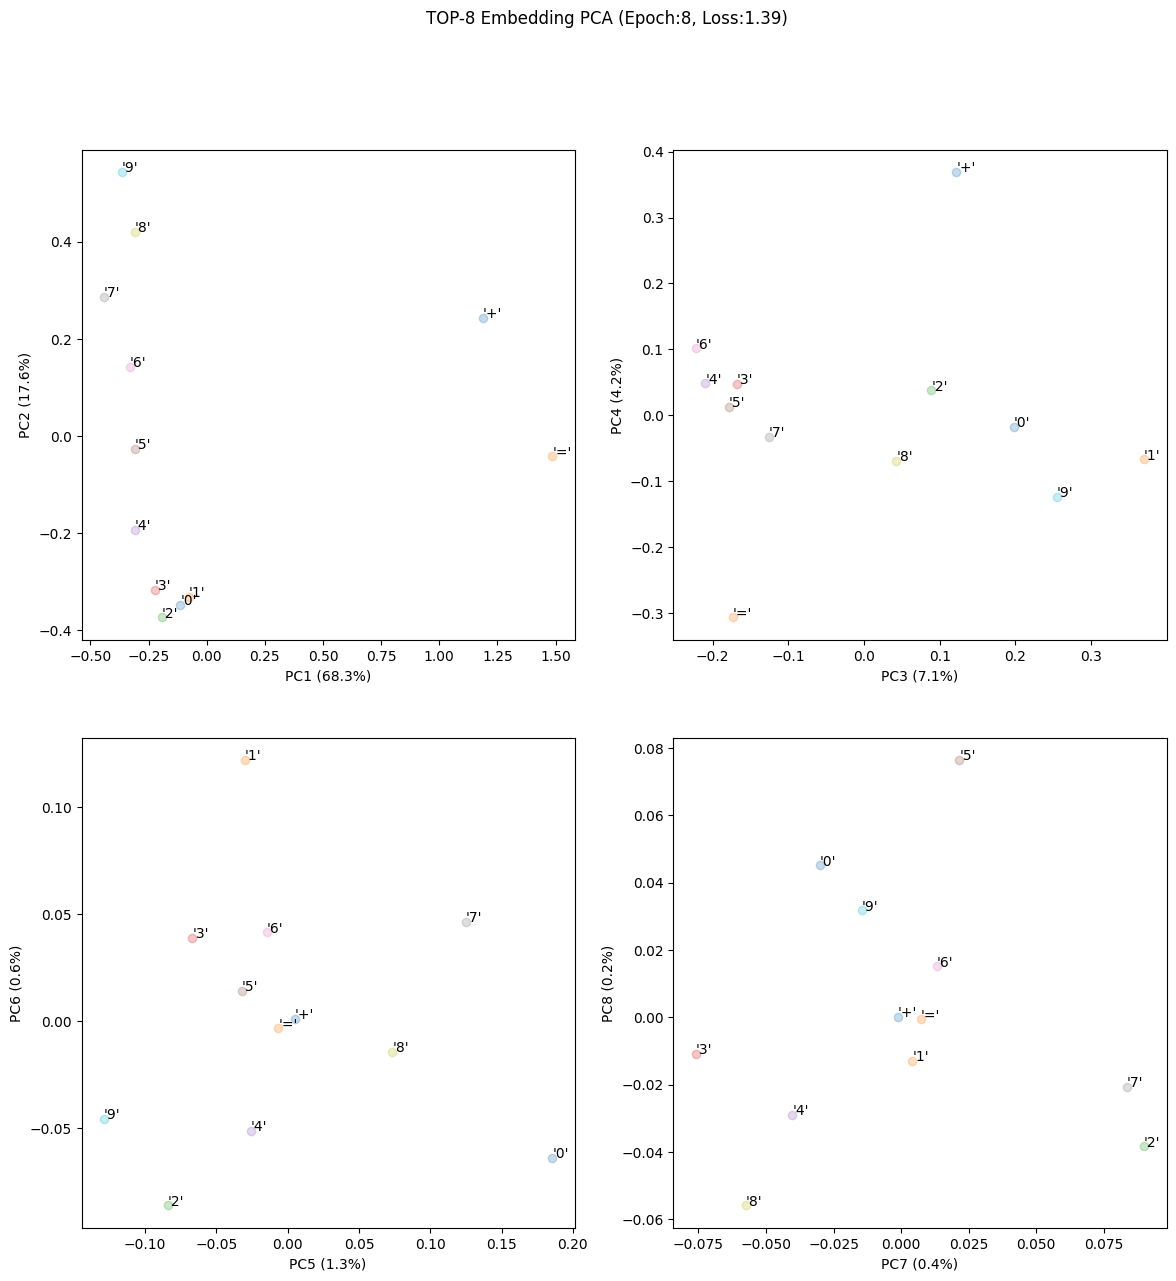

 36%|███▌      | 1778/5000 [00:34<01:03, 51.03it/s]


KeyboardInterrupt: 

In [20]:
# Train
model.train()

first = True
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            input_tensor = input_tensor[:,:MAX_LEN]
            target_tensor = target_tensor[:,:MAX_LEN]

            if first:
                print('input_tensor', input_tensor)
                print('target_tensor', target_tensor)
                first=False

            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            B, T, VOCAB_SIZE = output.shape
            logits = output.view(B*T, VOCAB_SIZE)
            targets = target_tensor.view(B*T)
            
            if COMPARE_RHS: # compare RHS
                eqi = (input_tensor[0] == char_to_idx('=')).nonzero(as_tuple=True)[0].item()
                lhs = torch.zeros_like(logits[:eqi])
                for i in range(eqi):
                    lhs[i][targets[i]] = 1
                rhs_logits = torch.cat((lhs, logits[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
                loss = F.cross_entropy(rhs_logits, targets)  
            else: # compare all (inefficient)
                loss = F.cross_entropy(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    vis_pca_in_epoch(epoch+1, losses[-1])

plt.title('Loss'); plt.plot(losses)

In [ ]:
print(model.token_embedding_table.weight.shape)
model.token_embedding_table.weight

torch.Size([13, 18])


Parameter containing:
tensor([[-1.8784e-02, -5.5777e-02,  6.3702e-02,  5.9068e-02,  5.5818e-02,
          2.4469e-02,  3.2183e-02, -5.8044e-02, -4.3520e-02, -3.6785e-02,
         -1.0222e-03,  3.1237e-02, -5.1546e-02,  1.0890e-02, -6.3234e-02,
          5.4551e-02,  1.9827e-02,  5.6019e-02],
        [-1.8457e-02, -5.2402e-02,  7.7669e-03, -3.0635e-02,  2.7396e-02,
          9.6009e-03, -3.8474e-02, -1.3508e-02,  6.8186e-03, -3.0258e-02,
          6.2462e-02, -4.4869e-03,  6.7527e-02,  2.2660e-02,  1.5135e-02,
          8.5808e-05, -2.4433e-02,  8.8820e-03],
        [-5.9754e-02, -6.1054e-02, -3.2698e-03,  3.5672e-02,  2.1521e-02,
          9.0369e-03,  3.5739e-02, -1.4818e-02,  8.8242e-03, -4.7138e-03,
          2.3397e-02, -1.4518e-02,  3.4249e-03, -2.1038e-03,  2.9499e-03,
          3.9520e-02, -3.2680e-02,  5.1832e-02],
        [-2.0750e-02, -7.2790e-03, -5.5176e-02,  1.9685e-02, -3.3584e-03,
          3.1666e-02, -4.7458e-02, -3.5527e-02, -3.5632e-02, -3.9905e-02,
         -1.9583e

In [ ]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

                input_tensor = input_tensor[:,:MAX_LEN]
                target_tensor = target_tensor[:,:MAX_LEN]
                
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)

                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  7+31=02
target_char:  ['0', '2']
output_char:  ['6', '6']
sentence:  28+11=39
target_char:  ['3', '9']
output_char:  ['6', '6']
sentence:  63+88=421
target_char:  ['4', '2', '1']
output_char:  ['6', '6', '1']
sentence:  0+93=93
target_char:  ['9', '3']
output_char:  ['6', '6']
sentence:  04+77=711
target_char:  ['7', '1', '1']
output_char:  ['6', '6', '1']
sentence:  57+38=851
target_char:  ['8', '5', '1']
output_char:  ['6', '6', '1']
sentence:  15+47=521
target_char:  ['5', '2', '1']
output_char:  ['6', '6', '1']
sentence:  13+6=73
target_char:  ['7', '3']
output_char:  ['6', '6']
sentence:  02+35=37
target_char:  ['3', '7']
output_char:  ['6', '6']
sentence:  1+86=96
target_char:  ['9', '6']
output_char:  ['6', '6']
sentence:  36+86=131
target_char:  ['1', '3', '1']
output_char:  ['6', '6', '1']
sentence:  11+63=74
target_char:  ['7', '4']
output_char:  ['6', '6']
sentence:  61+82=44
target_char:  ['4', '4']
output_char:  ['6', '6']
sentence:  21+75=96
target_char:  ['9',

In [ ]:
print("Accuracy: ", accuracy)  # Can be overestimated due to padding.

Accuracy:  0.2459016393442623


In [ ]:
# Write experimental results
if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{EPOCHS}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

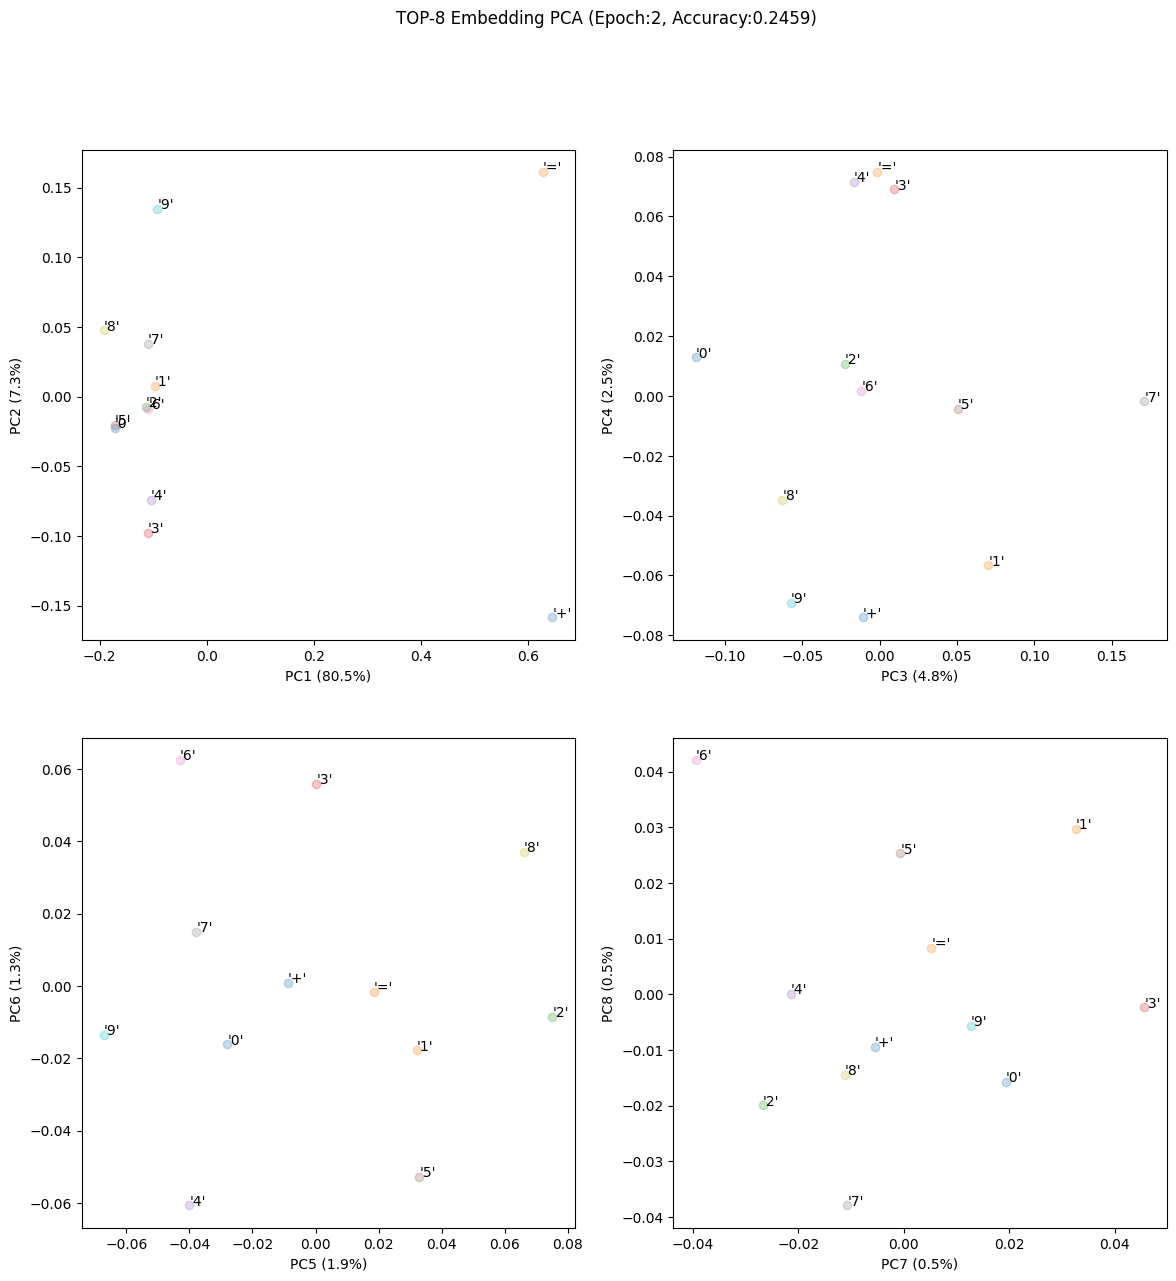

In [ ]:
vis_pca_in_epoch(epoch+1, accuracy=accuracy)

### Notes
- Learning only the RHS has no effect on the shape of the embedding vector. In fact, this is natural, because the LHS cannot be influenced because it is generated completely randomly.